In [1]:
import argparse
import concurrent.futures
import glob
import logging
import os
import random
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import yaml
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Range1d, UndoTool, WheelZoomTool, PanTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from hdbscan import HDBSCAN
from ogb.graphproppred import PygGraphPropPredDataset


from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose
from tqdm import tqdm



from utils import better_to_nx
from unsupervised.embedding_evaluation_riku import GeneralEmbeddingEvaluation
from unsupervised.encoder import MoleculeEncoder
from unsupervised.learning import GInfoMinMax
from unsupervised.utils import initialize_edge_weight
from unsupervised.view_learner import ViewLearner
from datasets.loaders import get_val_loaders, get_val_datasets
from sklearn.metrics import pairwise_distances

/Users/zs18656/Documents/GitHub/general-gcl
/Users/zs18656/Documents/GitHub/general-gcl


In [2]:
def repair_config(args):
    key_names = list(args.keys())
    
    new_cfg = {}
    for key_name in key_names:
        try:
            new_cfg[key_name] = args[key_name]["value"]
        except:
            pass
    
    return new_cfg

In [3]:
checkpoint = 'chem-100.pt'
# checkpoint = 'untrained'
# if checkpoint == "untrained":
#     checkpoint_path = "untrained"
    
checkpoint_path = f"outputs/{checkpoint}"
cfg_name = checkpoint.split('.')[0] + ".yaml"
config_path = f"outputs/{cfg_name}"
with open(config_path, 'r') as stream:
    args = yaml.safe_load(stream)
print(args)
args = repair_config(args)
print(args)
model = GInfoMinMax(MoleculeEncoder(emb_dim=args["emb_dim"], num_gc_layers=args["num_gc_layers"], drop_ratio=args["drop_ratio"], pooling_type=args["pooling_type"]),
                    proj_hidden_dim=args["emb_dim"])

{'wandb_version': 1, '_wandb': {'desc': None, 'value': {'cli_version': '0.13.4', 'framework': 'torch', 'is_jupyter_run': False, 'is_kaggle_kernel': False, 'python_version': '3.9.13', 'start_time': 1697703518.211216, 't': {1: [1, 5, 51, 53, 55, 77], 2: [1, 5, 51, 53, 55, 77], 3: [3, 13, 16, 23], 4: '3.9.13', 5: '0.13.4', 8: [5]}}}, 'batch_size': {'desc': None, 'value': 512}, 'dataset': {'desc': None, 'value': 'ogbg-molesol'}, 'drop_ratio': {'desc': None, 'value': 0.2}, 'emb_dim': {'desc': None, 'value': 300}, 'epochs': {'desc': None, 'value': 1024}, 'mlp_edge_model_dim': {'desc': None, 'value': 64}, 'model_lr': {'desc': None, 'value': 0.001}, 'no_molecules': {'desc': None, 'value': False}, 'no_socials': {'desc': None, 'value': True}, 'node_features': {'desc': None, 'value': False}, 'num_gc_layers': {'desc': None, 'value': 6}, 'pooling_type': {'desc': None, 'value': 'standard'}, 'reg_lambda': {'desc': None, 'value': 2.0}, 'seed': {'desc': None, 'value': 0}, 'view_lr': {'desc': None, 'val

In [4]:
if checkpoint != "untrained":
    model_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(model_dict['encoder_state_dict'])

In [5]:
my_transforms = Compose([initialize_edge_weight])
val_loaders, names = get_val_loaders(args["batch_size"], my_transforms)
val_datasets, names_datasets = get_val_datasets(my_transforms)

val_loaders = [val_loaders[0]] + val_loaders[5:]
val_datasets = [val_datasets[0]] + val_datasets[5:]
names = [names[0]] + names[5:]

Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molpcba/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molesol/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molclintox/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molfreesolv/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-mollipo/processed/val.pt


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


Processing twitch egos dataset
Entering ego processing loop


100%|███| 3083796/3083796 [00:00<00:00, 3189514.59it/s]
Processing...
Done!


Tree files exist


Processing...
Done!


Random files exist


Processing...
Done!


Facebook files exist


/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molpcba/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molesol/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molclintox/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molfreesolv/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-mollipo/processed/val.pt


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


Processing twitch egos dataset
Entering ego processing loop


100%|███| 3083796/3083796 [00:01<00:00, 2717482.69it/s]
Processing...
Done!


Tree files exist


Processing...
Done!


Random files exist


Processing...
Done!


Facebook files exist


In [6]:
print(names)

['ogbg-molpcba', 'facebook_large', 'twitch_egos', 'cora', 'roads', 'fruit_fly', 'trees', 'random', 'community']


## Scale embeddings <- todo


In [7]:
general_ee = GeneralEmbeddingEvaluation()
model.eval()
all_embeddings, separate_embeddings = general_ee.get_embeddings(model.encoder, val_loaders)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(all_embeddings)
separate_embeddings = [scaler.transform(emb) for emb in separate_embeddings]
all_embeddings = scaler.transform(all_embeddings)

In [9]:
all_embeddings.shape

(45000, 300)

In [10]:
N_per_dataset = [len(x) for x in separate_embeddings]

(45000, 300)
9 [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000] 45000


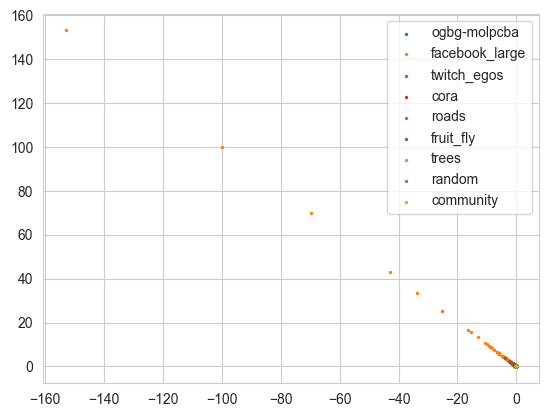

In [11]:
for i, embedding in enumerate(separate_embeddings):
#     print(names[i])
    plt.scatter(embedding[:,0], embedding[:,1], label = names[i], s =2)
plt.legend()
print(all_embeddings.shape)
print(len(separate_embeddings), N_per_dataset, np.sum([len(x) for x in separate_embeddings]))

Data(x=[29, 1], edge_index=[2, 62], edge_attr=[62, 1], y=[1, 128])
emb:  (300,)
Graph with 29 nodes and 31 edges


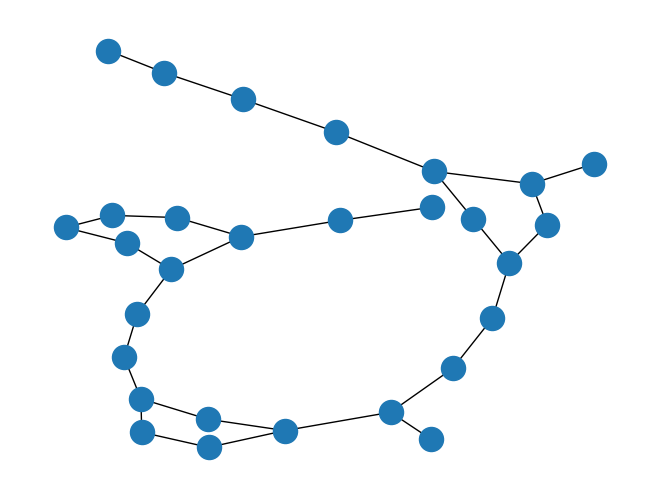

In [12]:
datasetID = 0
gdataset = val_datasets[datasetID]
embdataset = separate_embeddings[datasetID]

graphIDX = 0
graph_i = gdataset[graphIDX]
graph_i_embedding = embdataset[graphIDX]

print(graph_i)
print('emb: ', graph_i_embedding.shape)

g_nx = better_to_nx(graph_i)[0]
print(g_nx)
nx.draw(g_nx)

## Centroid positioning and data SV-decomposition

In [13]:
dataset_centroid_means = np.array([x.mean(axis = 0) for x in separate_embeddings])

In [14]:
dataset_centroid_means.shape

(9, 300)

In [15]:
def getSVD(X, s_only = True):
    # Assuming you have a dataset X with rows as instances and columns as features
    # Compute the mean of each feature
    mean = np.mean(X, axis=0)
    # Center the data
    X_centered = X - mean
    # Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    A = covariance_matrix
    U, s, VT = np.linalg.svd(A)
    if s_only:
        return s
    return U, s

In [16]:
seperate_svds = [getSVD(x) for x in separate_embeddings]

In [19]:
for idx, name in enumerate(names):
    np.save('Saved_embeddings_01_11_2023/chem_scaled_'+name+'.npy', separate_embeddings[idx])

In [18]:
np.save('Saved_embeddings_01_11_2023/chem_scaled.npy', all_embeddings)

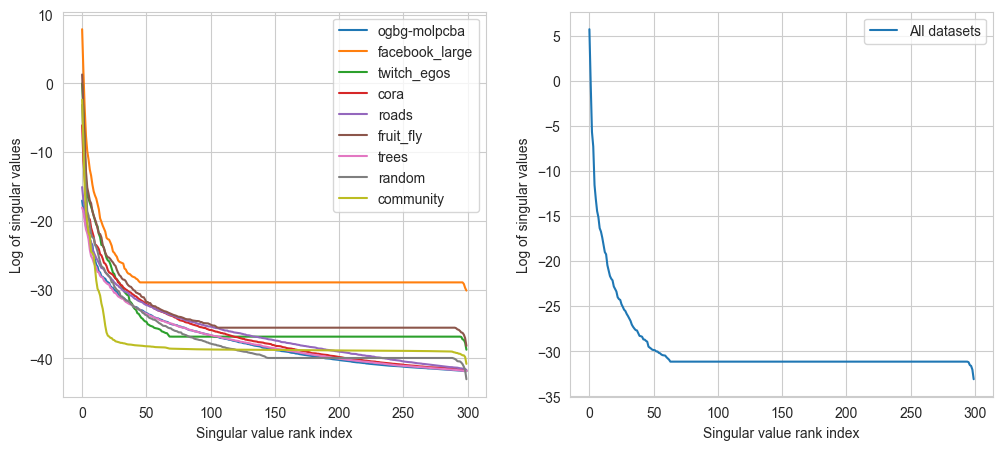

In [17]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
for idx, s in enumerate(seperate_svds):
    s = np.log(s)
    ax[0].plot(s, label = names[idx])
#     plt.show()
all_svd = getSVD(all_embeddings)
logged_all_svd = np.log(all_svd)
ax[1].plot(logged_all_svd, label = 'All datasets')

for a in ax:
    a.set_xlabel('Singular value rank index')
    a.set_ylabel('Log of singular values')
    a.legend()

In [23]:
true_label = []
for idx, i in enumerate(separate_embeddings):
    for j in i:
        true_label.append(idx)

/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Labels:
[0 0 0 ... 0 0 0]
Cluster Centers:
[300, 300, 300, 300, 300, 300, 300, 300, 300]


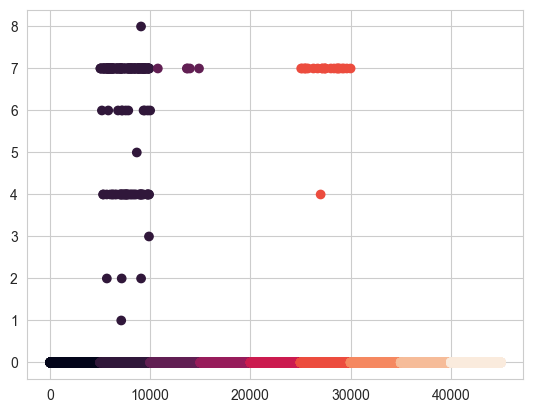

In [24]:
from sklearn.cluster import KMeans

X = all_embeddings

n_clusters = len(separate_embeddings)
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X, true_label)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_
# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Example: Printing the cluster labels
print("Cluster Labels:")
print(cluster_labels)

# Example: Printing the cluster centers
print("Cluster Centers:")
print([len(x) for x in cluster_centers])
plt.scatter(np.arange(len(cluster_labels)),cluster_labels, c = true_label)
plt.show()


In [ ]:
# X = all_embeddings
# ins = []
# for n_clusters in range(2,20):
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(X, true_label)
#     ins.append(kmeans.inertia_)
# plt.plot(ins)

In [ ]:
# from sklearn.metrics import adjusted_rand_score
# from sklearn.cluster import KMeans
# k = KMeans()
# k.fit(X)
# y = k.predict(X)
# ari = adjusted_rand_score(true_label, y)

# print("Adjusted Rand Index (ARI):", ari)

In [ ]:
cluster_centers

In [ ]:
dataset_centroid_means

In [ ]:
cluster_distances = pairwise_distances(dataset_centroid_means[:])

In [ ]:
plt.imshow(cluster_distances, cmap='viridis', origin='upper', interpolation='none')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.title('Pairwise Distances between Cluster Centers')
plt.xticks(range(n_clusters), names, rotation = 90)
plt.yticks(range(n_clusters), names, rotation = 0)


plt.show()

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# clf = MLPClassifier(hidden_layer_sizes=(1000,), max_iter = 1000)
# clf = make_pipeline(StandardScaler(),
#             SGDClassifier(max_iter=1000, tol=1e-3))
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf = LinearSVC(dual = False)

clf.fit(all_embeddings, true_label)
# all_embeddings.shape, len(true_label)

LinearSVC(dual=False)

In [26]:
pred = clf.predict(all_embeddings)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(names)
print(accuracy_score(pred, true_label))
print(confusion_matrix(pred, true_label))

['ogbg-molpcba', 'facebook_large', 'twitch_egos', 'cora', 'roads', 'fruit_fly', 'trees', 'random', 'community']
0.3838888888888889
[[4996  347  594  664 2718  611 4998 1203    0]
 [   0  963  520    1    0  171    0    6    4]
 [   0    2 1081   17    0    0    0    0    0]
 [   0 1651  851 2245    0 2025    0 1657    0]
 [   0  760    7 1695 2182 1569    0  758    0]
 [   0    0    0    0    0    0    0    0    0]
 [   4    9 1414   28  100    1    2    0    0]
 [   0  921  503  317    0  463    0  811    1]
 [   0  347   30   33    0  160    0  565 4995]]


In [27]:
print(classification_report(pred, true_label))

              precision    recall  f1-score   support

           0       1.00      0.31      0.47     16131
           1       0.19      0.58      0.29      1665
           2       0.22      0.98      0.35      1100
           3       0.45      0.27      0.33      8429
           4       0.44      0.31      0.36      6971
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00      1558
           7       0.16      0.27      0.20      3016
           8       1.00      0.81      0.90      6130

    accuracy                           0.38     45000
   macro avg       0.38      0.39      0.32     45000
weighted avg       0.67      0.38      0.44     45000



/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


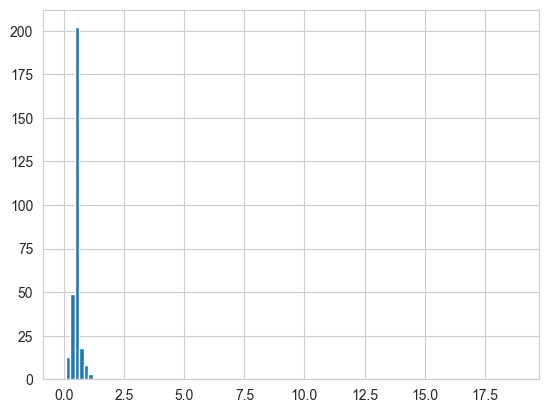

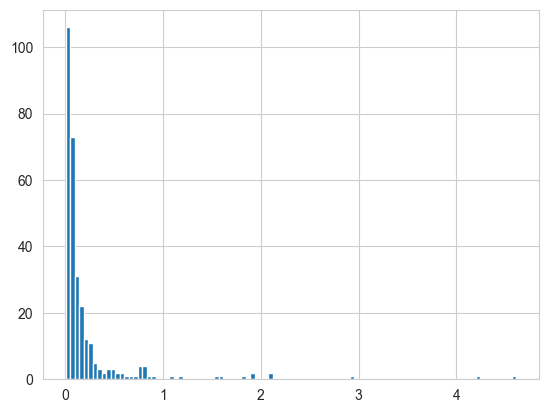

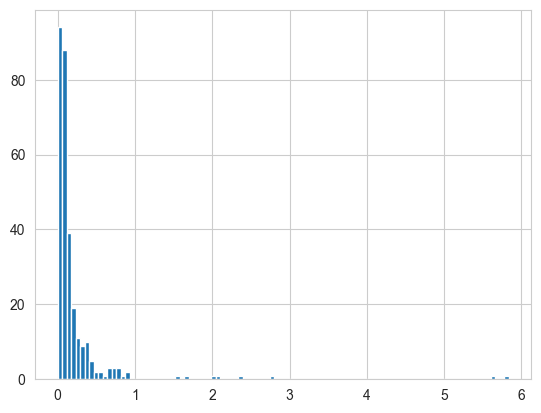

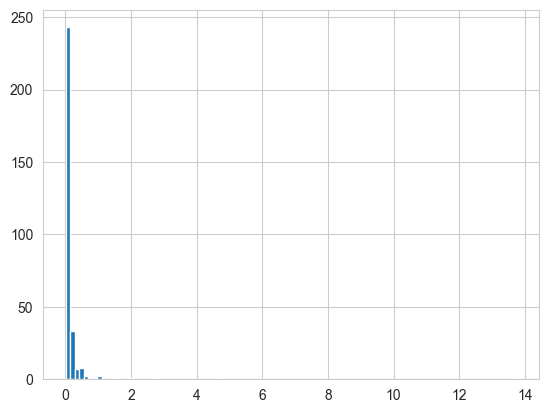

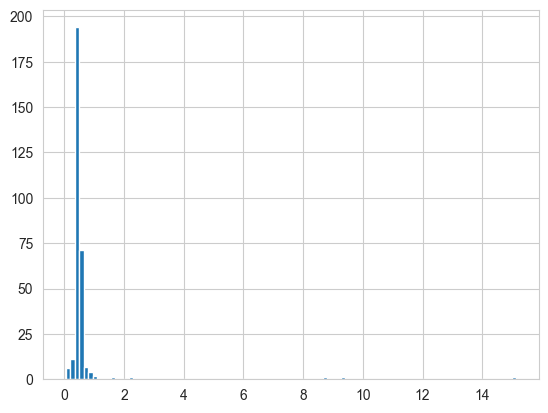

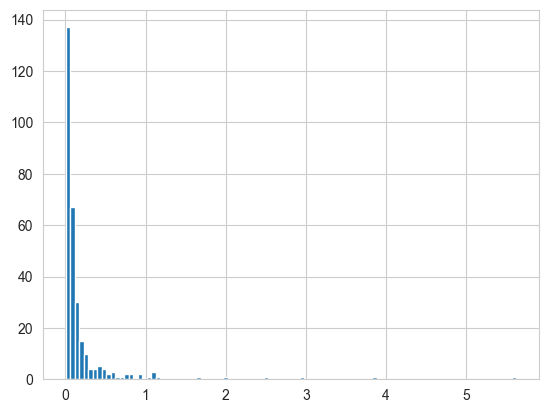

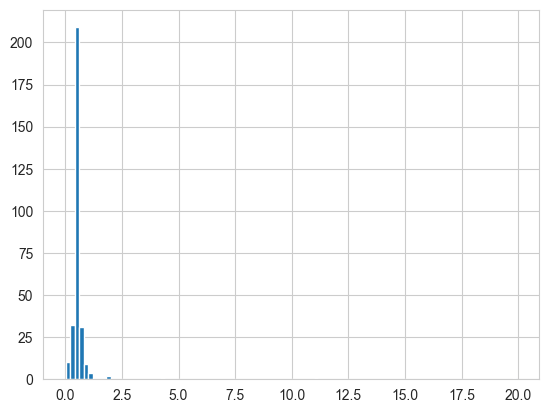

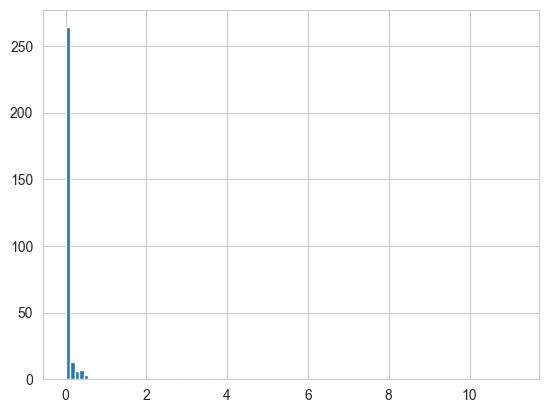

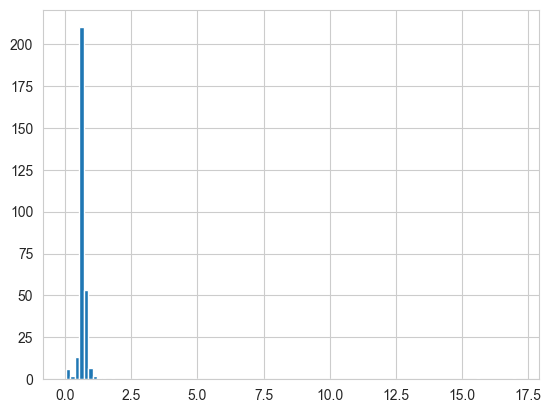

In [28]:
for x in clf.coef_:   
    plt.hist(abs(x), bins = 100)
    plt.show()

In [22]:
plt.plot(clf.coef_)

AttributeError: 'LinearSVC' object has no attribute 'coef_'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example confusion matrix (replace with your own data)
cm = confusion_matrix(pred, true_label)

# Define class labels
classes = names

plt.figure(figsize = (12,8))
# Create the heatmap
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add labels for the axes
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Add numerical annotations within each cell
thresh = cm.max() / 2.0
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Class')
plt.xlabel('Predicted Class')

# Display the plot or save it as an image
plt.show()  # To display the plot
# plt.savefig('confusion_matrix.png')  # To save it as an image
